# load data

In [117]:
import pandas as pd
import json
from ast import literal_eval
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime

In [118]:
df_all = pd.read_csv('../datasets/2025_csv/_chunk_0_100000.csv')

print(df_all.columns)

Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_properties',
       'event_time', 'event_type', 'language', 'library', 'os_name',
       'os_version', 'platform', 'processed_time', 'region',
       'server_received_time', 'server_upload_time', 'session_id', 'user_id',
       'user_properties', 'uuid'],
      dtype='object')


# process data - unnest

In [119]:
# Parse nested JSON columns
json_cols = ['data', 'event_properties', 'user_properties']
for col in json_cols:
    df_all[col] = df_all[col].apply(lambda x: literal_eval(str(x)) if pd.notna(x) else {})

# Flatten nested columns
df_all['event_slug'] = df_all['event_properties'].apply(lambda x: x.get('slug', 'unknown'))
df_all['event_displayName'] = df_all['event_properties'].apply(lambda x: x.get('displayName', 'unknown'))
df_all['user_roles'] = df_all['user_properties'].apply(lambda x: x.get('roles', []))

# Convert timestamps to a parsable time value
time_cols = ['client_event_time', 'event_time', 'server_received_time']
for col in time_cols:
    df_all[col] = pd.to_datetime(df_all[col], errors='coerce')

In [120]:
# session_id will be the uuid 
cols = ['session_id', 'event_time', 'client_event_time', 'user_id', 'user_roles', 'city', 'event_displayName', 'event_slug', 'event_type']
df_granular = df_all[cols]
df_granular.head()

,session_id,event_time,client_event_time,user_id,user_roles,city,event_displayName,event_slug,event_type
0,1737495248013,2025-01-21 21:34:08.373,2025-01-21 21:34:08.373,a5093711-4508-4f51-99f7-f7d493cd800a,[underwriter],Chicago,unknown,unknown,session_end
1,1737502763521,2025-01-21 23:39:20.650,2025-01-21 23:39:20.650,a5093711-4508-4f51-99f7-f7d493cd800a,[underwriter],Chicago,unknown,unknown,application-window-opened
2,1737502763521,2025-01-21 23:39:22.802,2025-01-21 23:39:22.802,a5093711-4508-4f51-99f7-f7d493cd800a,[underwriter],Chicago,unknown,unknown,dashboard:my-book::view
3,1737502763521,2025-01-21 23:39:22.802,2025-01-21 23:39:22.802,a5093711-4508-4f51-99f7-f7d493cd800a,[underwriter],Chicago,unknown,my-book,dashboard:my-book:layout:render
4,1737502763521,2025-01-21 23:39:22.986,2025-01-21 23:39:22.986,a5093711-4508-4f51-99f7-f7d493cd800a,[underwriter],Chicago,Actions,actions,dashboard:my-book:widget:render


# process data - aggregate by session id

In [ ]:
# The original ordering is not sorted by session_id
df_granular = df_granular.sort_values(['session_id', 'event_time'])

# Group together consequetive events in the same session
df_granular['session_change'] = df_granular['session_id'].ne(df_granular['session_id'].shift()).cumsum()
df = df_granular.groupby('session_change').agg(
    session_id=('session_id', 'first'),

    start_time=('event_time', 'first'),
    num_events=('event_time', 'count'),
    elapsed_time=('event_time', lambda x: (x.max() - x.min()).total_seconds() / 60 if len(x) > 1 else 0),

    user_id=('user_id', 'first'),
    user_roles=('user_roles', 'first'),
    city=('city', 'first'),
    
    event_displayNames=('event_displayName', list),
    event_slugs=('event_slug', list),
    event_types=('event_type', list)
).reset_index(drop=True)

print(df['session_id'].is_unique)

df.head(5)


True
(4843, 10)
(100000, 33)


# simple visualizations

In [ ]:
print(df_all.shape) # raw data
print(df.shape) # processed data

average_num_events = df['num_events'].mean()
average_elapsed_time = df['elapsed_time'].mean()

print(f"The average number of events is: {average_num_events}")
print(f"The elapsed time (minutes) is: {average_elapsed_time}")

(100000, 33)
(4843, 10)
The average number of events is: 20.648358455502787
The elapsed time (minutes) is: 6.964784682359419


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

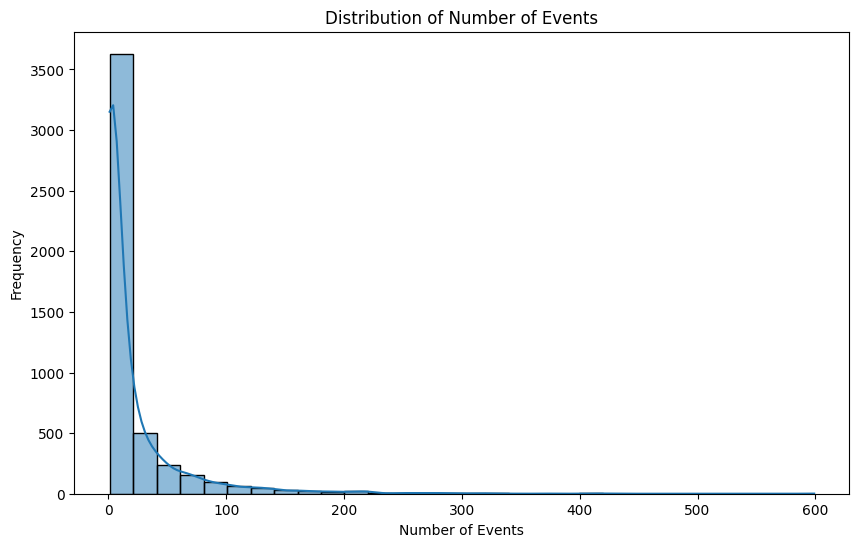

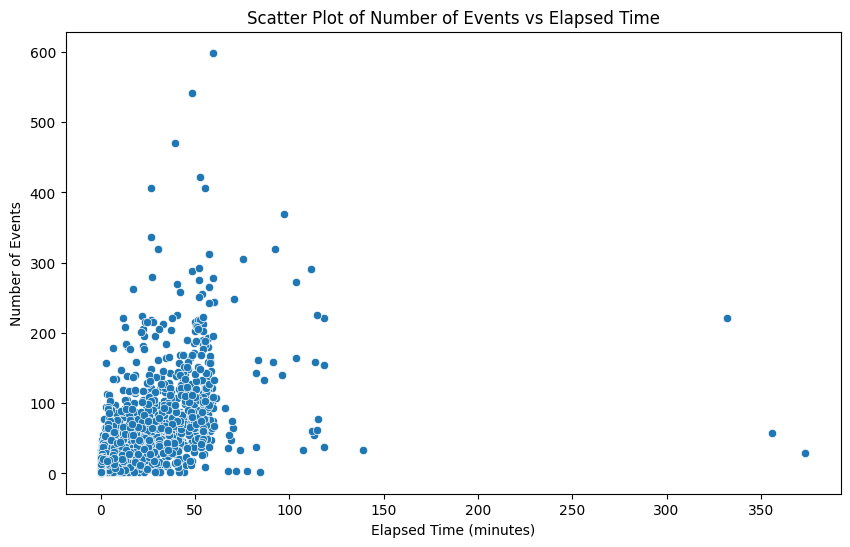

In [116]:
# histogram: num_events
plt.figure(figsize=(10, 6))
sns.histplot(df['num_events'], kde=True, bins=30)
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Events')
plt.show()

# scatterplot: num_events vs elapsed_time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='elapsed_time', y='num_events', data=df)
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Number of Events')
plt.title('Scatter Plot of Number of Events vs Elapsed Time')
plt.show()
